# Charged Particle Motion: $B_{Dipole}$, $E=0$
Boris particle tracing code for computing charged particle motion in Earth's Magnetopshere with dipole magnetic field and $E=0$.

## Preamble

In [4]:
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D
import time

# Use %matplotlib notebook to change to a zoom-able display.
%matplotlib inline

## Useful Functions

### earth3D

Function to create and plot a 3D earth

In [2]:
def earth3D(rad):
    '''
    rad is in earth radii [RE]

    '''
    ns     = 100 # numbner samples
    stride = 1

    # phi; goes from [0:2*PI]
    phi = np.linspace(0.,2.*np.pi,ns)

    # theta; goes from [0:PI]
    tht = np.linspace(0.,np.pi,ns)

    x = rad*np.outer(np.cos(phi), np.sin(tht))
    y = rad*np.outer(np.sin(phi), np.sin(tht))
    z = rad*np.outer(np.ones(np.size(phi)), np.cos(tht))

    ax.plot_surface(x, y, z, linewidth=0.0, cstride=stride, rstride=stride, color = 'b')

### Magnetic field - Dipole

Earth's dipole field in terms of magnetic dipole moment $|\vec{m}|=7.79 \times 10^{22} \mathrm{Am}^{2}$, 

$$\vec{B}=\frac{\mu_{0}}{4 \pi r^{3}}[3(\vec{m} \cdot \hat{r}) \hat{r}-\vec{m}] \tag{Garcia-Farieta 2019; 1}$$

In [3]:
def B(r):
    
    phi = np.radians(11.7)                                  # tilt of magnetic axis [rad]
    mu = -7.94e22*np.array([.0, np.sin(phi), np.cos(phi)])  # magnetic moment of earth [A*m^2]
    M0 = 1.0e-7                                             # mu_0 [N*A−2] /4*PI 
    RE = 6371000                                            # equatorial radius of Earth [m] 
    
    r = r*RE
    rmag = np.sqrt(np.dot(r, r))
    
    Bdip = M0*(3.*r*np.dot(mu,r)/(rmag**5)-mu/(rmag**3))
    return Bdip

## Setup
Computes motion of an electric charge in a magnetic dipole field using Boris particle pushing method.

In [5]:
# start time
time_start = time.time()

mp = 1.6e-27           # proton mass [kg]
me = 9.1e-31           # electron mass [kg]
qe = 1.603E-19         # proton charge [C]

dt = 0.01              # Time step [s]
tf = 6000              # Final time [s]
steps = int(tf/dt)     # Number of iterations
print('s',steps)

# Allocate memory to output
tdat = np.zeros(steps)         # time [s]
rdat = np.zeros((steps,3))     # position [r]
vdat =  np.zeros((steps,3))    # velocity [km/s]

# creating charged particle
m = 4.*mp              # mass of simulated particle [kg]
q = 2.*qe              # charge of simulated particle [C]

# set initial conditions
rdat[0] = np.array([1., -7.85, -1.53])
vdat[0] = np.array([0.,.3,.3])

s 600000


'\n# sample conditions for ref.\n\nrdat[0] = np.array([1., -7.85, -1.53])\nvdat[0] = np.array([0.,.3,.3])\n\n'

## Simulation: Boris Method

There is a `boris.py` module with a `boris` function. To use `boris.boris` with the parameters derived above, `from boris import boris` then copy and past the printed line below into the command line.

In [6]:
print('tdat, tdrift,  vdat, rdat, emag = b.boris(tf={0:0d},'
                                                'r0=[{1:0.4f}, {2:0.4f}, {3:0.4f}],'
                                                'v0=[{4:0.4f}, {5:0.4f}, {6:0.4f}],'
                                                'm={7:0.4e},'
                                                'q={8:0.4e},'
                                                'gs={9:1.2f},'
                                                'kp={10:2.1f}, tdir="bw")'
      .format(tf, *rdat[0], *vdat[0], m, q, 2.0, 8.5))

tdat, tdrift,  vdat, rdat, emag = b.boris(tf=6000,r0=[1.0000, -7.8500, -1.5300],v0=[0.0000, 0.3000, 0.3000],m=6.4000e-27,q=3.2060e-19,gs=2.00,kp=8.5, tdir="bw")


Boris particle pusher method with magnetic field and no electric field

In [7]:
for i in tqdm(range(0, steps-1)):
    
        r = rdat[i]
        v = vdat[i]
        
        tdat[i] = i*dt

        # calculate dipole field
        B0 = B(r)
        
        # set electric field to 0
        E = 0
        
        c0 = (dt*q*B0)/(2*m)
        
        # push step 1 - update velocity with half electrostatic contribution
        v1 = v + (q*E*dt)/(2*m)
        
        # push step 2 - rotated via the magnetic field contribution 
        ax = v1 + np.cross(v1,c0)
        bx = (2*c0)/(1+c0**2)
        v2 = v1 + np.cross(ax,bx)
        
        # push step 3 - updated again with another half of the electrostatic push
        vnew = v2 + (q*E*dt)/(2*m)
        
        # update position
        rnew = r + vnew*dt
        
        # append to data arrays
        vdat[i+1] = vnew
        rdat[i+1] = rnew

  0%|          | 0/599999 [00:00<?, ?it/s]

100%|██████████| 599999/599999 [01:50<00:00, 5438.33it/s]


## Plots

### Motion of Particle in Dipole Field

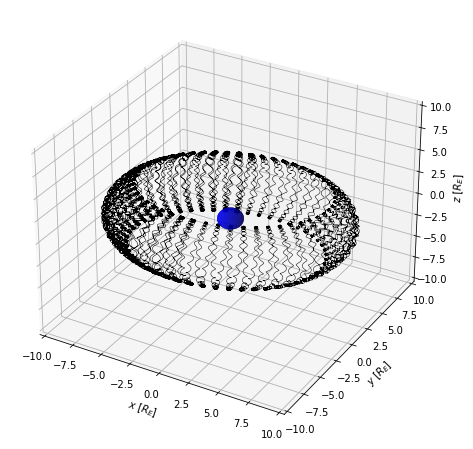

runtime = 463.02167201042175 s (7.717027866840363 min)


In [8]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

# plot dipole field data
ax.plot3D(rdat[:,0],rdat[:,1],rdat[:,2],'k',linewidth=0.5)

# plot 3D earth
earth3D(1)

# graph correction, keeps origin (0,0,0) at center
ranges = []
ranges.append(math.ceil(max(abs(rdat[:,0]))))
ranges.append(math.ceil(min(abs(rdat[:,0]))))
ranges.append(math.ceil(max(abs(rdat[:,1]))))
ranges.append(math.ceil(min(abs(rdat[:,1]))))
ranges.append(math.ceil(max(abs(rdat[:,2]))))
ranges.append(math.ceil(min(abs(rdat[:,2]))))

axrng = max(ranges)

ax.set_xlim([-axrng, axrng])
ax.set_ylim([-axrng, axrng])
ax.set_zlim([-axrng, axrng])

# plot attributes
#ax.set_box_aspect([1,1,.5])
ax.set_xlabel("$x$ [$R_E$]")
ax.set_ylabel("$y$ [$R_E$]")
ax.set_zlabel("$z$ [$R_E$]")

# save figure
# fname = 'dipolef'
# plt.savefig('../bin/'+fname+'.png',bbox_inches='tight', dpi=150)

plt.show()

# end time
time_end = time.time()

# print runtime
runtime = time_end - time_start
print(f"runtime = {runtime} s ({runtime/60} min)")

### Velocity vs. Time

Text(108.125, 0.5, '$|V|$ [$m/s$]')

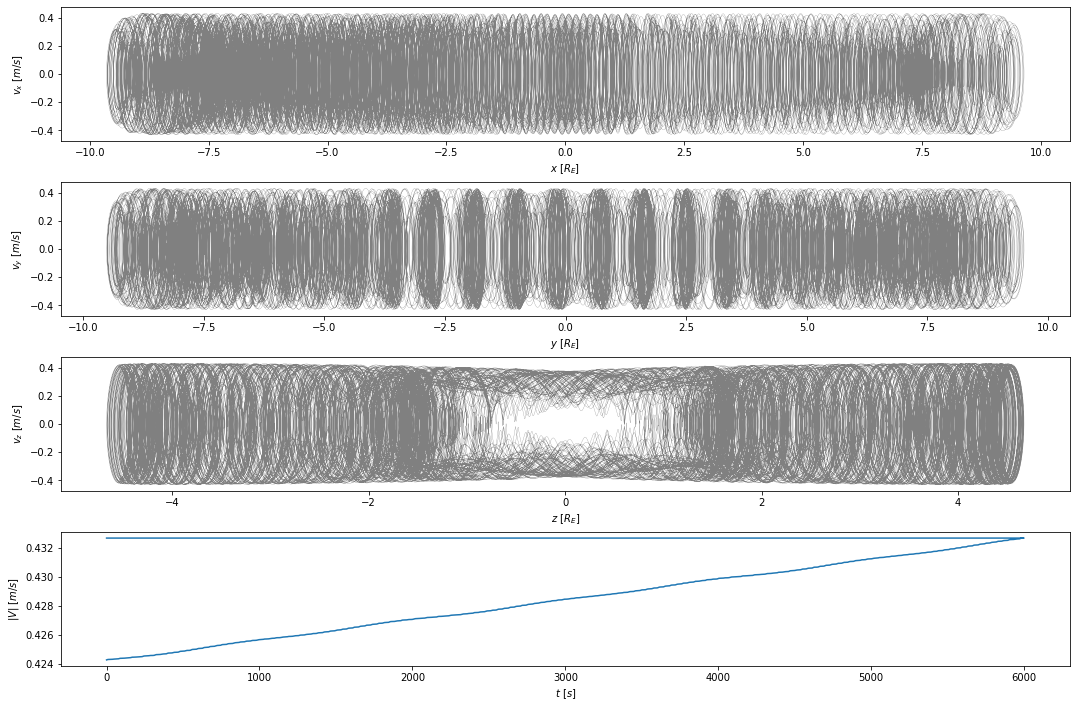

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15, 10))
plt.tight_layout(pad=2.)

ax1.plot(rdat[:,0],vdat[:,0], c='grey', linewidth=0.25)
ax1.set_xlabel("$x$ [$R_E$]")
ax1.set_ylabel("$v_x$ [$m/s$]")


ax2.plot(rdat[:,1],vdat[:,1], c='grey', linewidth=0.25)
ax2.set_xlabel("$y$ [$R_E$]")
ax2.set_ylabel("$v_y$ [$m/s$]")


ax3.plot(rdat[:,2],vdat[:,2], c='grey', linewidth=0.25)
ax3.set_xlabel("$z$ [$R_E$]")
ax3.set_ylabel("$v_z$ [$m/s$]")

ax4.plot(tdat, np.sqrt(np.sum(vdat**2, axis=1)))
ax4.set_xlabel("$t$ [$s$]")
ax4.set_ylabel("$|V|$ [$m/s$]")

#### References
* J. E. García-Farieta and A. Hurtado, “Simulation of charged particles in Earth’s magnetosphere: an approach to the Van Allen belts”, Rev. Mex. Fis. E, vol. 65, no. 1 Jan-Jun, pp. 64–70, Jan. 2019.
* https://en.wikipedia.org/wiki/Magnetic_dipole
* http://physicsinsights.org/dipole_field_1.html
* Notes from J. Shuster, *Numerical Applications for Space Weather* 2020 

